# Context

The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 
This project is to work through this notebook to help the company understand the results of an A/B test run by an e-commerce website, should they implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [55]:
import pandas as pd
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [1]:
import pandas as pd
import numpy as np
from numpy import percentile

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import shapiro

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

In [34]:
data = pd.read_csv('ab_data.csv')

In [35]:
country = pd.read_csv('countries.csv')

In [36]:
df = pd.merge(data, country, on='user_id', how='inner')

In [37]:
df.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


# Descriptive Statistics + Clean Data

Check rows of duplicate data

In [38]:
dups = df.duplicated()
print(dups.any())

True


The number of rows in the dataset

In [39]:
df.shape[0]

294482

The number of unique users in the dataset

In [40]:
df.user_id.nunique()

290585

Check duplicate user_id

In [41]:
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted,country
23,767017,31:31.5,treatment,new_page,0,US
194,656468,31:05.8,treatment,old_page,0,US
229,773693,52:52.3,control,new_page,0,UK
244,733976,14:56.6,treatment,new_page,0,US
251,704650,55:59.5,treatment,old_page,0,US
...,...,...,...,...,...,...
286595,767924,23:31.0,control,old_page,1,US
287370,858910,20:38.0,treatment,old_page,1,US
287675,921581,48:28.8,treatment,new_page,0,US
289041,742781,40:22.2,control,new_page,0,US


Check mismatch between group and page

In [42]:
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]
n_mismatch = df_mismatch.shape[0]
print(f"The number of mismatched rows:{n_mismatch} rows" )
print("Percent of mismatched rows:%.2f%%" % (n_mismatch/df.shape[0]*100))

The number of mismatched rows:3893 rows
Percent of mismatched rows:1.32%


In [43]:
df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page")
                |(df["group"]=="control")&(df["landing_page"]=="old_page")]

Check duplicate user_id and drop

In [44]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted,country
1947,773192,55:59.6,treatment,new_page,0,US
251037,759899,07:36.1,treatment,new_page,0,US
251038,759899,20:29.0,treatment,new_page,0,US
251039,759899,20:29.0,treatment,new_page,0,US


In [45]:
df2.drop_duplicates(subset="user_id",inplace=True) 

In [46]:
df2.shape

(290585, 6)

Conversion Rate

In [47]:
df_counts = pd.DataFrame({"Control_COUNT": df2[df2.group=="control"].converted.value_counts(),
              "Treatment_COUNT": df2[df2.group=="treatment"].converted.value_counts(),
              "Control_RATIO": df2[df2.group=="control"].converted.value_counts()/ len(df2[df2.group=="control"]),
              "Trement_RATIO": df2[df2.group=="treatment"].converted.value_counts() / len(df2[df2.group=="treatment"])})
df_counts

,Control_COUNT,Treatment_COUNT,Control_RATIO,Trement_RATIO
0,127785,128047,0.879614,0.881193
1,17489,17264,0.120386,0.118807


EDA

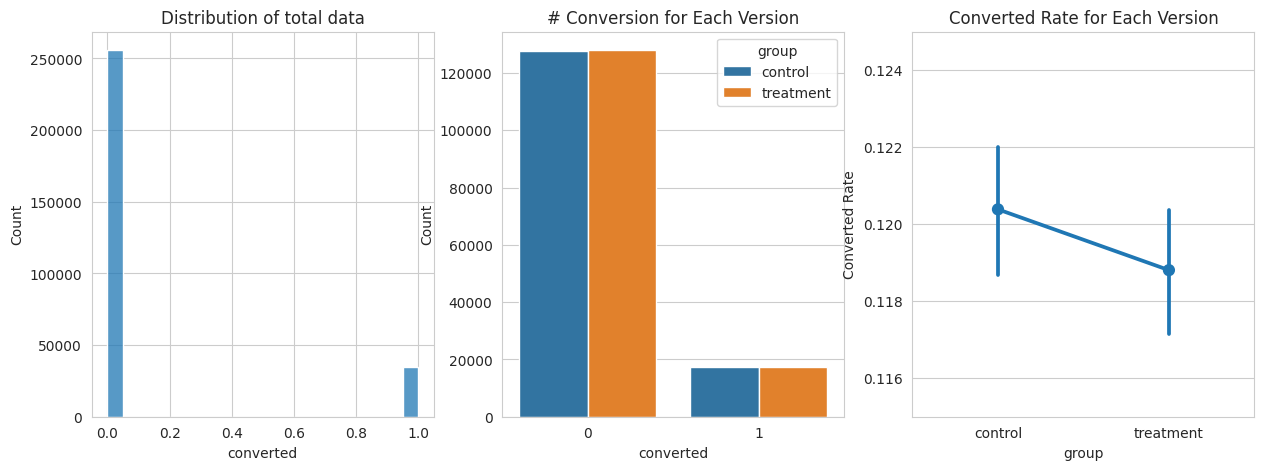

In [48]:
fig, axes = plt.subplots(1,3)

sns.histplot(x="converted", data=df2, ax=axes[0])
axes[0].set_title("Distribution of total data")

sns.countplot(x="converted", data=df2, hue="group", ax=axes[1])
axes[1].set(title="# Conversion for Each Version", ylabel="Count")

sns.pointplot(x="group", y="converted",data=df2, ax=axes[2])
axes[2].set_ylim([0.115, 0.125])
axes[2].set(title="Converted Rate for Each Version",ylabel="Converted Rate")

plt.show()

# Sanity Check

In [49]:
def check_any_assignment_imbalance(df):
    df1 = df[['user_id', 'group']].groupby(['group']).count().reset_index() 
    # count the number of users in treatment vs. control
    print(df1)
    pvalue = stats.binom_test(df1[df1['group'] == 'treatment']['user_id'].values[0], 
                              n=df1['user_id'].sum(),
                              p=0.5, 
                              alternative='two-sided') 
    # test whether the treatment vs. control has the equal sample size
    print(pvalue)

In [50]:
check_any_assignment_imbalance(df2)

       group  user_id
0    control   145274
1  treatment   145311
0.9467544748207741


# Hypothesis Testing

##Z Ttest

In [61]:
def perform_z_test(df):
    n_treatment = df[df['group'] == 'treatment']['user_id'].count() # the number of users in treatment
    n_control = df[df['group'] == 'control']['user_id'].count() # the number of users in control
    
    p_treatment = 1.0*df[df['group'] == 'treatment']['converted'].sum()/n_treatment 
    # the probability of a user in treatment to convert
    p_control = 1.0*df[df['group'] == 'control']['converted'].sum()/n_control 
    # the probability of a user in control to convert
    
    p_delta = p_treatment - p_control # the delta of the probability of a user to convert in treatment vs. control
    print(p_delta)
    
    p = 1.0*(df[df['group'] == 'treatment']['converted'].sum() + df[df['group'] == 'control']['converted'].sum())/(n_treatment+n_control)
    # the probability of a user to convert under null hypothesis
    var = p*(1-p)
    # the variance of the probability of a user to convert under null hypothesis
    se = np.sqrt(var*(1/n_treatment + 1/n_control))
    # the pooled standard error of the z test
    z_statistic = p_delta/se # the z statistic
    
    pvalue = 2*norm.cdf(-abs(z_statistic)) # the p value of the z test
    print(pvalue)
    
    lower = p_delta - norm.ppf(0.975)*se # the lower bound of the confidence interval
    upper = p_delta + norm.ppf(0.975)*se # the upper bound of the confidence interval
    print(lower)
    print(upper)

In [62]:
perform_z_test(df2)

-0.0015790565976871451
0.18965258971881804
-0.003938675600319155
0.0007805624049448648


##Linear Regression+Covariate Adjustment

y = ax + b + c1*z1 + c2*z2
<br>y: 1 if converted and 0 if not
<br>x: 1 if treatment and 0 if control
<br>z1: 1 if UK and 0 if not
<br>z2: 1 if US and 0 if not
<br>a: the delta of the probability of a user to convert in treatment vs. control after covariate adjustment

In [64]:
formula = 'converted ~ C(group) + C(country)'
lm1 = ols(formula, df2).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Fri, 07 Apr 2023   Prob (F-statistic):              0.178
Time:                        19:01:09   Log-Likelihood:                -85266.
No. Observations:              290585   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.11

#Heterogeneous Treatment Effect

y = a*x + b + c1*z1 + c2*z2 + h1*x*z1 + h2*x*z2
<br>y: 1 if converted and 0 if not
<br>x: 1 if treatment and 0 if control
<br>z1: 1 if UK and 0 if not
<br>z2: 1 if US and 0 if not
<br>h1 and h2 indicate whether there are any heterogenenous treatment effetcs

In [66]:
formula = 'converted ~ C(group) + C(country) + C(group)*C(country)'
lm2 = ols(formula, df2).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.467
Date:                Fri, 07 Apr 2023   Prob (F-statistic):              0.197
Time:                        19:03:34   Log-Likelihood:                -85264.
No. Observations:              290585   AIC:                         1.705e+05
Df Residuals:                  290579   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------